In [15]:
import os
import json
import numpy as np
import laspy as lp
import pyvista as pv
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

def get_las_file_paths(root_dir):
    las_file_paths = []
    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.las'):
                las_file_paths.append(os.path.join(root, file))
    return las_file_paths

def view_cloud_pv(points):
    xyz = points[:, :3]  # Primeras 3 columnas: X, Y, Z
    rgb = points[:, 3:6]  # Columnas 4-6: R, G, B
    
    # Normalizar RGB de 16-bit (LAS) a 8-bit (0-255)
    if np.issubdtype(rgb.dtype, np.integer) and rgb.max() > 255:
        rgb = (rgb // 256).astype(np.uint8)  # Conversión a 8-bit
    
    # Crear objeto PolyData con coordenadas
    cloud = pv.PolyData(xyz)
    
    # Añadir colores RGB como array asociado a los puntos
    cloud["RGB"] = rgb.astype(np.uint8)  # Asegurar tipo uint8
    
    # Configurar plotter
    plotter = pv.Plotter()
    plotter.add_mesh(
        cloud,
        scalars="RGB",  # Usar el array RGB
        rgb=True,       # Indicar que son canales RGB
        point_size=3,   # Tamaño de los puntos
        opacity=1       # Opacidad total
    )
    
    plotter.show()

def get_points(path):
    las = lp.read(path)
    points = np.vstack((las.x, las.y, las.z)).transpose()
    rgb = np.vstack((las.red, las.green, las.blue)).transpose()
    data_points = np.hstack((
        points,
        rgb,
        np.expand_dims(las.return_number, -1),
        np.expand_dims(las.number_of_returns, -1)
    ))

    single = data_points[data_points[:, -1] == 1][:, :6]  #XYZRGB
    return single

def get_roi(points, p=0.05):
    # Obtener límites originales
    x_min = np.min(points[:, 0])
    x_max = np.max(points[:, 0])
    y_min = np.min(points[:, 1])
    y_max = np.max(points[:, 1])
    
    # Calcular 5% del largo de cada eje
    x_offset = p * (x_max - x_min)
    y_offset = p * (y_max - y_min)
    
    # Ajustar límites hacia adentro
    new_x_min = x_min + x_offset
    new_x_max = x_max - x_offset
    new_y_min = y_min + y_offset
    new_y_max = y_max - y_offset
    
    return new_x_min, new_x_max, new_y_min, new_y_max

def bresenham_line(start=(10, 10), end=(10, 60)):
    # Unpack start and end points
    x1, y1 = np.array(start, dtype=np.int32).copy()
    x2, y2 = np.array(end, dtype=np.int32).copy()


    # Calculate differences
    dx = x2 - x1
    dy = y2 - y1

    # Determine if the line is steep (more vertical than horizontal)
    is_steep = abs(dy) > abs(dx)

    # Swap coordinates if the line is steep (for easier handling)
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Ensure the line is always drawn left-to-right
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1

    # Recalculate differences after the possible swap
    dx = x2 - x1
    dy = y2 - y1

    # Error term initialized to half of dx
    error = dx // 2
    ystep = 1 if y1 < y2 else -1  # Determines whether to increment or decrement y

    # List to store the generated points
    points = []
    y = y1

    # Main loop for Bresenham's algorithm
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)  # Swap x and y if the line is steep
        points.append(coord)

        # Update error term
        error -= abs(dy)

        # If error is negative, adjust y and reset the error term
        if error < 0:
            y += ystep
            error += dx

    return points


In [16]:
import numpy as np
from scipy.spatial import Delaunay

def vectorized_area_2d(p1, p2, p3):
    # Vectorized area calculation for many triangles
    return 0.5 * np.abs((p2[:,0]-p1[:,0])*(p3[:,1]-p1[:,1]) - (p3[:,0]-p1[:,0])*(p2[:,1]-p1[:,1]))

def volume_from_points(points, rasante):
    new_points = points.copy()
    new_points[:, 2] -= rasante
    # Remove points below rasante
    new_points = new_points[new_points[:, 2] >= 0]
    
    # Triangulate 2D projection
    tri = Delaunay(new_points[:, :2])
    simplices = tri.simplices  # shape (M, 3)
    
    # Extract triangle vertices coordinates in vectorized form
    p1 = new_points[simplices[:, 0]]
    p2 = new_points[simplices[:, 1]]
    p3 = new_points[simplices[:, 2]]
    
    # Compute areas vectorized
    areas = vectorized_area_2d(p1, p2, p3)
    
    # Compute average heights vectorized
    avg_heights = (p1[:, 2] + p2[:, 2] + p3[:, 2]) / 3
    
    # Compute volumes vectorized
    volumes = areas * avg_heights
    
    # Sum all volumes
    total_volume = np.sum(volumes)
    
    return total_volume

In [17]:
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator

def generate_dem(points, rasante):
    # Extraer y procesar coordenadas
    x, y, z = points[:, 0], points[:, 1], points[:, 2] - rasante
    z = np.clip(z,0, 4)
    
    grid_spacing = np.mean(np.sqrt(np.diff(x)**2 + np.diff(y)**2)) * 2
    
    # Crear dimensiones de la grilla
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    
    cols = int(np.ceil((x_max - x_min) / grid_spacing))
    rows = int(np.ceil((y_max - y_min) / grid_spacing))

    # Binning para promedio de elevaciones
    grid_sum = np.zeros((rows, cols))
    grid_count = np.zeros((rows, cols))
    
    xi = ((x - x_min) / grid_spacing).astype(int)
    yi = ((y_max - y) / grid_spacing).astype(int)
    
    np.add.at(grid_sum, (yi, xi), z)
    np.add.at(grid_count, (yi, xi), 1)
    
    dem = np.divide(grid_sum, grid_count, where=grid_count != 0)
    dem[grid_count == 0] = np.nan
    
    # --- Interpolación combinada lineal + nearest ---
    mask = ~np.isnan(dem)
    y_coords, x_coords = np.where(mask)

    xx = x_min + (x_coords + 0.5) * grid_spacing
    yy = y_max - (y_coords + 0.5) * grid_spacing

    # Primera interpolación: Lineal
    linear_interp = LinearNDInterpolator(list(zip(xx, yy)), dem[mask])

    grid_x, grid_y = np.meshgrid(
        x_min + (np.arange(cols) + 0.5) * grid_spacing,
        y_max - (np.arange(rows) + 0.5) * grid_spacing
    )

    dem_filled = dem.copy()
    nan_mask = np.isnan(dem)
    dem_filled[nan_mask] = linear_interp(grid_x[nan_mask], grid_y[nan_mask])

    # Segunda interpolación: Nearest para NaN residuales
    if np.isnan(dem_filled).any():
        print("Aplicando Nearest para NaN residuales")
        nearest_interp = NearestNDInterpolator(list(zip(xx, yy)), dem[mask])
        residual_nan = np.isnan(dem_filled)
        dem_filled[residual_nan] = nearest_interp(grid_x[residual_nan], grid_y[residual_nan])

    return dem_filled

In [18]:

df = pd.read_csv('data_sqm.csv')

POZAS = {}

for index, row in df.iterrows():
    fecha = row['Fecha']
    poza = row['Poza'].replace('-','').lower()
    rasante = row['Rasante (m)']
    cota_salm = row['Cota Salm. (m)']
    cota_sal = row['Cota Sal (m)']
    sal = row['Sal (cm)']
    salmuera = row['Salmuera (cm)']

    if poza not in POZAS:
        POZAS[poza] = {}

    POZAS[poza][fecha] = {
        'Rasante (m)': rasante,
        'Cota Salmuera sqm (m)': cota_salm,
        'Cota Sal sqm (m)': cota_sal,
        'Sal sqm (cm)': sal,
        'Salmuera sqm (cm)': salmuera
    }


In [27]:
POZAS.get('hk13sectorb').get('06/05/2025')

{'Rasante (m)': 2300.772,
 'Cota Salmuera sqm (m)': 2301.65,
 'Cota Sal sqm (m)': 2301.6585,
 'Sal sqm (cm)': 88.65,
 'Salmuera sqm (cm)': -0.85}

['', 'home', 'diego', 'Downloads', 'data_sqm', '06_05_2025', 'hk-13-sector-a_100m_7ms_100khz_plena-luz_0_0.las']
['hk-13-sector-a', '100m', '7ms', '100khz', 'plena-luz', '0', '0']
hk13sectora 06/05/2025
{'Rasante (m)': 2300.772, 'Cota Salmuera sqm (m)': 2301.672, 'Cota Sal sqm (m)': 2301.6585, 'Sal sqm (cm)': 88.65, 'Salmuera sqm (cm)': 1.35}
10719.143209053067


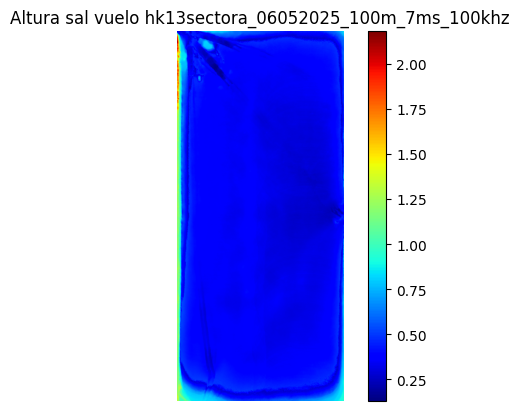

['', 'home', 'diego', 'Downloads', 'data_sqm', '06_05_2025', 'hk-13-sector-b_100m_7ms_100khz_plena-luz_0_0.las']
['hk-13-sector-b', '100m', '7ms', '100khz', 'plena-luz', '0', '0']
hk13sectorb 06/05/2025
{'Rasante (m)': 2300.772, 'Cota Salmuera sqm (m)': 2301.65, 'Cota Sal sqm (m)': 2301.6585, 'Sal sqm (cm)': 88.65, 'Salmuera sqm (cm)': -0.85}
8792.719884490929


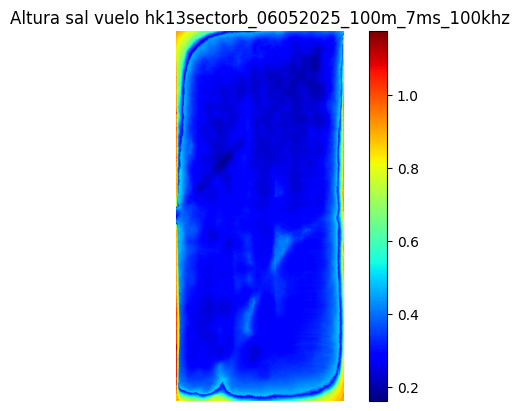

['', 'home', 'diego', 'Downloads', 'data_sqm', '06_05_2025', 'hk-13-sector-c_100m_7ms_100khz_plena-luz_0_0.las']
['hk-13-sector-c', '100m', '7ms', '100khz', 'plena-luz', '0', '0']
hk13sectorc 06/05/2025
{'Rasante (m)': 2300.772, 'Cota Salmuera sqm (m)': 2301.577, 'Cota Sal sqm (m)': 2301.6585, 'Sal sqm (cm)': 88.65, 'Salmuera sqm (cm)': -8.15}
7024.2040737575935


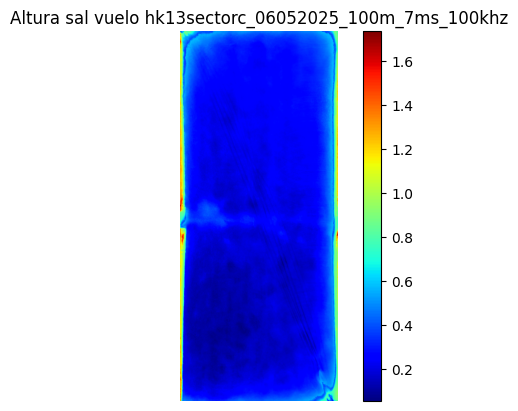

['', 'home', 'diego', 'Downloads', 'data_sqm', '06_05_2025', 'hk-13-sector-d_100m_7ms_100khz_plena-luz_0_0.las']
['hk-13-sector-d', '100m', '7ms', '100khz', 'plena-luz', '0', '0']
hk13sectord 06/05/2025
{'Rasante (m)': 2300.772, 'Cota Salmuera sqm (m)': 2301.575, 'Cota Sal sqm (m)': 2301.6585, 'Sal sqm (cm)': 88.65, 'Salmuera sqm (cm)': -8.35}
7745.040841343627


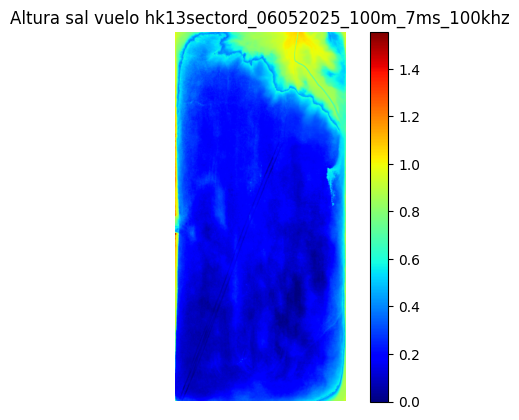

In [29]:
import gc 

root_directory = '/home/diego/Downloads/data_sqm/06_05_2025'
las_file_paths = sorted(get_las_file_paths(root_directory))

for path in las_file_paths:
    print(path.split('/'))  
    ## Get info
    _,_,_,_,_,date,filename = path.split('/')
    DATE = date.replace('_','/')
    date = date.replace('_','')
    print(filename[:-4].split('_'))
    POZA, H, V, F, _, _, _ = filename[:-4].split('_')
    SECTOR = None
    if len(POZA.split('-')) != 1:
        #POZA, SECTOR = POZA.split('-')
        POZA = POZA.replace('-','').lower()
    print(POZA, DATE)
    PDATA = POZAS.get(POZA).get(DATE)
    print(PDATA)
    rasante = float(PDATA.get('Rasante (m)'))

    ## Analysis
    points = get_points(path)
    x_min, x_max, y_min, y_max = get_roi(points)
    mask = (points[:, 0] >= x_min) & (points[:, 0] <= x_max) & \
       (points[:, 1] >= y_min) & (points[:, 1] <= y_max)
    roi_points = points[mask]

    del points
    gc.collect()    

    HSAL = np.mean(roi_points[:,2] - rasante)*100
    AREA = (x_max - x_min) * (y_max - y_min) 
    VOL = volume_from_points(roi_points, rasante)
    print(VOL)
    
    ## Create DEM
    dem = generate_dem(roi_points, rasante)
    
    del roi_points
    gc.collect()
    
    ## Save DEM and data
    dem_pil = Image.fromarray(dem)
    os.makedirs(f'{root_directory}/results', exist_ok=True)
    save_path = f'{root_directory}/results/{POZA}_{date}_{H}_{V}_{F}' if SECTOR is None else f'{root_directory}/results/{POZA}-{SECTOR}_{date}_{H}_{V}_{F}'
    dem_pil.save(f'{save_path}.tiff')

    del dem_pil
    gc.collect()
    
    h, w = dem.shape
    d1 = bresenham_line(start=(0, 0), end=(h-1,w-1))
    d2 = bresenham_line(start=(h-1, 0), end=(0,w-1))
    dem_d1 = np.array([(idx, dem[x][y]) for idx, (x, y) in enumerate(d1) ])
    dem_d2 = np.array([(idx, dem[x][y]) for idx, (x, y) in enumerate(d2) ])
       
    result = {
        'altura sal (cm) (lidar)': HSAL,
        'Area poza medida': AREA,
        'volumen_sales': VOL,
        'data_sqm': PDATA,
        'diagonal1':{
            'unit':     '[m]',
            'mean':     float(np.mean([i for i in dem_d1[:,1] if not np.isnan(i)])),
            'x_axis':   dem_d1[:,0].tolist(),
            'y_axis':   dem_d1[:,1].tolist()

        },
        'diagonal2':{
            'unit':     '[m]',
            'mean':     float(np.mean([i for i in dem_d2[:,1] if not np.isnan(i)])),
            'x_axis':   dem_d2[:,0].tolist(),
            'y_axis':   dem_d2[:,1].tolist()
        }
    }

    with open(f'{save_path}.json', 'w') as f:
        json.dump(result, f, indent=4)

    ## Save DEM png OPTINAL
    plt.imshow(dem, cmap='jet')
    plt.colorbar()
    plt.title(f'Altura sal vuelo {save_path.split("/")[-1]}')  
    plt.axis('off')
    plt.savefig(f'{save_path}.png')
    plt.show()

    del dem
    gc.collect()